# 5.3 Lab: Cross-Validation and the Bootstrap

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd 
import math
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import *
from sklearn import datasets, linear_model
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from collections import OrderedDict

import seaborn as sns
sns.set_theme()
sns.set_style("ticks")

## 5.3.1 The Validation Set Approach

We explore the use of the validation set approach in order to estimate the test error rates that result from fitting various linear models on the `Auto` data set.

In [3]:
Auto = pd.read_csv('https://www.statlearning.com/s/Auto.csv', header=0, na_values='?')
Auto = Auto.dropna().reset_index(drop=True) # drop the observation with NA values and reindex the obs from 0
Auto.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


Before we begin, we use the `random_state=42` parameter in order to set a seed for `python`'s random number generator, this is so that the user of this lab will obtain precisely the same results as those in the discussions below. 

It is generally a good idea to set a random seed when performing an analysis such as cross-validation that contains an
element of randomness, so that the results obtained can be reproduced precisely at a later time.

We begin by using the `train_test_split()` function to split the set of observations into two halves, by selecting a random subset of $196$ observations out of the original $392$ observations. We refer to these observations as the training set.

We then use the `Train` to fit a linear regression using only the observations corresponding to the training set.

In [4]:
# split the data into training and record the index of train samples
Train, Valid = train_test_split(Auto, test_size=196, random_state=2)

In [5]:
# start to build the model
lm = smf.ols ('mpg~horsepower', data=Train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     308.5
Date:                Thu, 20 Oct 2022   Prob (F-statistic):           5.83e-42
Time:                        14:28:32   Log-Likelihood:                -592.23
No. Observations:                 196   AIC:                             1188.
Df Residuals:                     194   BIC:                             1195.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     40.8582      1.036     39.431      0.0

If we choose a different training set instead, then we will obtain somewhat different errors on the validation set.

We now  use
 the `predict()` function to estimate the response for all $392$ observations, and we  use the `mean()` function to calculate the MSE of the $196$ observations in the test set. 

In [6]:
# to follow the book, get prediction for all the observations in the dataset
# here we use ~ select to exclude the result of the training samples
lm = smf.ols ('mpg~horsepower', data=Train).fit()
preds = lm.predict(Valid)
square_error = (Valid['mpg'] - preds)**2
print('-------- Test error for 1st order model --------')
print(np.mean(square_error))

-------- Test error for 1st order model --------
23.442643969985753


Therefore, the estimated test MSE for the linear regression fit is $25.57$. We can use the `I(X**2.0)` and `I(X**3.0)` function to estimate the test error for the quadratic and cubic regressions.

In [7]:
# build a model with 2nd order features  
lm2 = smf.ols ('mpg~horsepower + I(horsepower ** 2.0)', data=Train).fit()
preds = lm2.predict(Valid)
square_error = (Valid['mpg'] - preds)**2
print('--------Test error for 2nd order--------')
print(square_error.mean())

--------Test error for 2nd order--------
18.550198801910682


In [8]:
# build a model with 3rd order features  
lm3 = smf.ols ('mpg~horsepower + I(horsepower ** 2.0) + I(horsepower ** 3.0)', data=Train).fit()
preds = lm3.predict(Valid)
square_error = (Valid['mpg'] - preds)**2
print('--------Test rror for 3rd order--------')
print(np.mean(square_error))

--------Test rror for 3rd order--------
18.595222294405268


Using this split of the observations into a training set and a validation set, we find that the validation set error rates for the models with linear, quadratic, and cubic terms are $23.44$, $18.55$, and $18.59$, respectively.

If we look at the summmary for 3rd order regression, the coefficient of the 3rd order term is not statistically significant. We will use this as Supporting evidence for the above claim. 

In [9]:
print(lm3.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     145.5
Date:                Thu, 20 Oct 2022   Prob (F-statistic):           3.30e-49
Time:                        14:28:33   Log-Likelihood:                -569.28
No. Observations:                 196   AIC:                             1147.
Df Residuals:                     192   BIC:                             1160.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               56.7613 

These results are consistent with our previous findings: 

a model that predicts `mpg` using a quadratic function of `horsepower` performs better than a model that involves only a linear function of `horsepower`, and there is little evidence in favor of a model that uses a cubic function of `horsepower`.

## 5.3.2 Leave-One-Out Cross-Validation
The LOOCV estimates only keep one sample in the validation data and use the rest of the data to train the model. This way the training model has similar dataset comparing to the model trained on entire dataset.

The LOOCV estimate can be automatically computed for any generalized linear model using the `ols()` and `cross_val_score()` functions.  In the lab for Chapter 4, we used the `logit()` function to perform logistic regression.

In [10]:
# OLS fit 
ols_fit = smf.ols('mpg~horsepower', data=Auto).fit()
print(ols_fit.params)

Intercept     39.935861
horsepower    -0.157845
dtype: float64


In [11]:
# GLM fit. Compare with OLS fit, the coeffs are the same
glm_fit = smf.glm('mpg~horsepower', data=Auto).fit()
print(glm_fit.params)

Intercept     39.935861
horsepower    -0.157845
dtype: float64


In [12]:
# trying CV in Python is not as easy as that in R. It will require some manual coding.
# to use some of implemented function in Python, we use Sklearn for linear model 
# from sklearn.model_selection import KFold, cross_val_score
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.linear_model import LinearRegression
# from sklearn.pipeline import Pipeline

In [13]:
# let us re-train the model in sklearn
model = LinearRegression()
model.fit(Auto.horsepower.to_frame(), Auto.mpg)
print(model.intercept_)
print(model.coef_)

39.93586102117045
[-0.15784473]


yield identical linear regression models. In this lab, we will  perform linear regression using  the `glm()` and `LinearRegression()` rather than the `ols()`.

LOOCV use folds equal to # of observations. We could also choose other number of folds.

In [14]:
n_split = Auto.shape[0]
test = cross_val_score(model, 
                       Auto.horsepower.to_frame(),
                       Auto.mpg, 
                       cv=Auto.shape[0],  
                       scoring='neg_mean_squared_error',                        
                       n_jobs=-1)
print(np.mean(-test))

24.23151351792923


We can repeat this procedure for increasingly complex polynomial fits.
To automate the process, we use the  `for` loop to initiate a  which iteratively fits polynomial regressions for polynomials of order $i=1$ to $i=10$, computes the associated cross-validation error.
We begin by initializing the vector. 

In [15]:
# for higher order polynomial fit, we use pipline tool.
# this step may take a few mins
A = OrderedDict()
n_split = Auto.shape[0]
for porder in range(1, 11, 1):
    model = Pipeline([('poly', PolynomialFeatures(degree=porder)), ('linear', LinearRegression())])    
    test = cross_val_score(model, 
                           Auto.horsepower.to_frame(),
                           Auto.mpg, 
                           cv=n_split,  
                           scoring='neg_mean_squared_error', n_jobs=-1)
    A[str(porder)] = np.mean(-test)

In [16]:
A

OrderedDict([('1', 24.231513517929226),
             ('2', 19.248213124489393),
             ('3', 19.334984064131373),
             ('4', 19.4244303095644),
             ('5', 19.033216775741238),
             ('6', 18.97488351827742),
             ('7', 19.12593012097048),
             ('8', 19.224202151694772),
             ('9', 19.13396063366187),
             ('10', 18.946435735916353)])

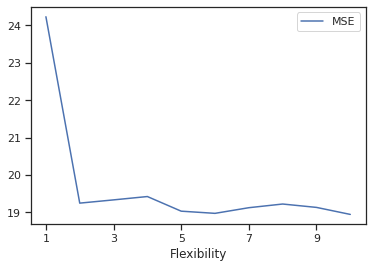

In [17]:
pd.DataFrame(A.values(), columns=['MSE'], index=pd.Index(A.keys(), name='Flexibility')).plot();

As in Figure 5.4, we see a sharp drop in the estimated test MSE between the linear and quadratic fits, but then no clear improvement from using higher-order polynomials.

## 5.3.3 k-Fold Cross-Validation

 Below we use $k=10$, a common choice for $k$, on the `Auto` data set.
We once again set a random seed and initialize a vector in which we will store the CV errors corresponding to the polynomial fits of orders one to ten.

In [18]:
# K-fold validation is exactly same as LOO with different n_splits parameter setup. 
# the computation time is much shorter than that of LOOCV.
np.random.seed(2)
A = OrderedDict()
n_split = 10
for porder in range(1, 11, 1):
    model = Pipeline([('poly', PolynomialFeatures(degree=porder)), ('linear', LinearRegression())])    
    test = cross_val_score(model,
                           Auto.horsepower.to_frame(),
                           Auto.mpg, 
                           cv=n_split,  
                           scoring='neg_mean_squared_error',                           
                           n_jobs=-1)
    A[str(porder)] = np.mean(-test)

In [19]:
A

OrderedDict([('1', 27.439933652339857),
             ('2', 21.235840055802118),
             ('3', 21.336606183328794),
             ('4', 21.35388699422229),
             ('5', 20.90563054316467),
             ('6', 20.799631258355426),
             ('7', 20.953366101157698),
             ('8', 21.077180808300973),
             ('9', 21.036717405054862),
             ('10', 20.980983108692712)])

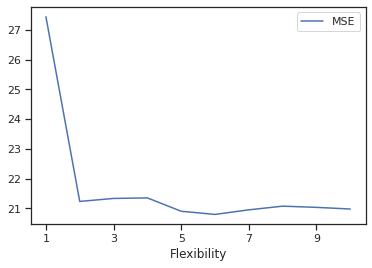

In [20]:
pd.DataFrame(A.values(), columns=['MSE'], index=pd.Index(A.keys(), name='Flexibility')).plot();

We still see little evidence that using cubic or higher-order polynomial terms would leads to lower test error than simply using a quadratic fit.

We saw in Section 5.3.2 that the two numbers associated with `delta` are essentially the same when LOOCV is performed. When we instead perform $k$-fold CV, then the two numbers associated with `delta` differ slightly. The first is the standard $k$-fold CV estimate, as in ( 5.3). The second is a bias-corrected version. On this data set, the two estimates are very similar to each other.

## 5.3.4 The Bootstrap
Bootstrap means sampling with replacement. To eliminate the effect of sample size, the norm practice is to sample the same size as original dataset with replacement.

Bootstrap can be used in a lot of other places, such as estimating the accuracy of a linear regression model coeffcients / Conduct non-parametric testing (permutation test) / Estimate some complicated probability 

We illustrate the use of the bootstrap in the simple example of Section 5.2, as well as on an example involving estimating the accuracy of the linear regression model on the `Auto` data set.

### Estimating the Accuracy of a Statistic of Interest

One of the great advantages of the bootstrap approach is that it can be applied in almost all situations. No complicated mathematical calculations are required. Performing a bootstrap analysis in `python` entails only two steps. First, we must create a function that computes the statistic of interest. Second, we use the `boot_python()` function, which is defined below, to perform the bootstrap by repeatedly sampling observations from the data set with replacement.

The `Portfolio` data set in the `ISLR2` package is simulated data of $100$ pairs of returns, generated in the fashion described in Section 5.2.

To illustrate the use of the bootstrap on this data, we must first create a function, `alpha_fn()`, which takes as input the $(X,Y)$ data as well as a vector indicating which observations should be used to estimate $\alpha$. The function then outputs the estimate for $\alpha$ based on the selected observations.

In [21]:
Portfolio = pd.read_csv('https://raw.githubusercontent.com/tvanzyl/Sharing_ISL_python/master/data/Portfolio.csv', header=0)

To illustrate the use of the bootstrap on this data, we must first create a function, alpha_fn(), 
which takes as input the (X, Y) data as well as a vector indicating which observations should be used to estimate alpha.


In [22]:
def alpha_fn(data, index):
    X = data.X.iloc[index]
    Y = data.Y.iloc[index]
    return (np.var(Y) - np.cov(X,Y)[0,1])/(np.var(X) + np.var(Y) - 2 * np.cov(X, Y)[0,1])

This function *returns*, or outputs, an  estimate for $\alpha$ based on applying ( 5.7) to the observations indexed by the argument `index`.
For instance, the following command tells `python` to estimate $\alpha$ using
all $100$ observations.

In [23]:
alpha_fn(Portfolio, range(0,100))

0.5766511516104116

The next command  uses the `choice()` function to randomly select
$100$ observations from the range $1$ to $100$, with replacement. This is equivalent
to constructing a new bootstrap data set and recomputing $\hat{\alpha}$
based on the new data set.

In [24]:
# generate one set of random index with 100 elements. The array has been sorted to show there are repeat elements.
np.sort(np.random.choice(range(0, 100), size=100, replace=True))

array([ 1,  4,  4,  7,  8,  8,  8,  9, 10, 15, 15, 16, 17, 18, 19, 20, 21,
       22, 22, 22, 26, 31, 31, 32, 33, 34, 34, 37, 38, 39, 39, 40, 40, 40,
       42, 43, 43, 43, 43, 46, 46, 47, 49, 49, 50, 50, 51, 52, 52, 55, 56,
       57, 58, 60, 61, 62, 63, 63, 66, 67, 67, 68, 68, 69, 70, 70, 70, 70,
       72, 72, 73, 74, 75, 75, 76, 76, 79, 80, 81, 82, 82, 83, 83, 84, 85,
       86, 87, 88, 90, 90, 90, 90, 90, 91, 95, 95, 96, 96, 97, 99])

In [25]:
# recall the previous function with a random set of input. 
alpha_fn(Portfolio, np.random.choice(range(0, 100), size=100, replace=True))

0.632327580798003

In [26]:
# since I am not aware of boot like function in python, I just defined an ad-hoc function called boot_python()
def boot_python(data, input_fun, iteration):
    n = Portfolio.shape[0]
    idx = np.random.randint(0, n, (iteration, n))
    stat = np.zeros(iteration)
    for i in range(len(idx)):
        stat[i] = input_fun(data, idx[i])
    
    return {'Mean': np.mean(stat), 'STD': np.std(stat)}
    

We can implement a bootstrap analysis by performing this command many times, recording all of
the corresponding estimates for $\alpha$, and computing the resulting
standard deviation.
However, the `boot_python()` function automates this approach. Below we produce $R=1,000$ bootstrap estimates for $\alpha$.


In [27]:
boot_python(Portfolio, alpha_fn, 1000)

{'Mean': 0.5811900883897445, 'STD': 0.09408713019844589}

The final output shows that using the original data, $\hat{\alpha}=0.5758$,
and that the bootstrap estimate for ${\rm SE}(\hat{\alpha})$ is $0.0897$.

### Estimating the Accuracy of a Linear Regression Model

The bootstrap approach can be used  to assess the
variability of the coefficient estimates and predictions from a statistical learning method. Here we use the bootstrap approach in order to assess the variability of
the estimates for $\beta_0$ and $\beta_1$, the intercept and slope terms for the linear regression model
that uses  `horsepower` to predict `mpg` in the `Auto` data set. We will compare the estimates obtained using the bootstrap to those obtained using the formulas
for ${\rm SE}(\hat{\beta}_0)$ and ${\rm SE}(\hat{\beta}_1)$ described
in Section 3.1.2.

In [28]:
#TODO: Exercise

The standard error estimates for $\hat{\beta}_0$ and $\hat{\beta}_1$ obtained using the formulas from
Section 3.1.2 are $0.717$ for the intercept and $0.0064$ for the slope. Interestingly, these are somewhat different from the
estimates obtained using the bootstrap.  Does this indicate a problem with the bootstrap? In fact, it suggests the opposite.  Recall that the standard formulas given in Equation 3.8 on page 66 rely on certain assumptions. For example, they depend
on the unknown parameter $\sigma^2$, the noise variance. We then estimate $\sigma^2$ using the RSS. Now although the formulas for the standard errors do not rely on the linear model being correct, the estimate for $\sigma^2$ does.

We see in Figure 3.8 on page 91 that there is a non-linear relationship in the data, and so the residuals from a linear fit will be inflated, and so will $\hat{\sigma}^2$. Secondly, the standard formulas assume (somewhat unrealistically) that the $x_i$ are fixed, and all the variability comes from the variation in the errors $\epsilon_i$. The bootstrap approach does not rely on any of these assumptions, and so it is likely giving a more accurate estimate of the standard errors of $\hat{\beta}_0$ and $\hat{\beta}_1$.

Below you should compute the bootstrap standard error estimates and the standard
linear regression estimates that result from fitting the quadratic model to the data. Since this model provides a good fit to the data (Figure 3.8), there is now a better correspondence between the bootstrap estimates and the standard estimates of ${\rm SE}(\hat{\beta}_0)$, ${\rm SE}(\hat{\beta}_1)$ and ${\rm SE}(\hat{\beta}_2)$.

In [29]:
#TODO: Exercise